# Model Analysis

## Set UP

In [1]:
# ============================================================
# Global Parameters — Model Validation Notebook
# ============================================================

import os

ROUND_NAME = "round_01"
MODEL_NAME = "xgboost_baseline"

# Diretórios do pipeline
BASE_DIR = "/Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso"

SPLIT_DIR  = os.path.join(BASE_DIR, "data", "splits", ROUND_NAME)
MODEL_DIR  = os.path.join(BASE_DIR, "model", ROUND_NAME)
RESULTS_DIR = os.path.join(BASE_DIR, "results")

# Arquivos gerados pelo treino
MODEL_FILE = os.path.join(MODEL_DIR, f"{MODEL_NAME}.json")
PREDS_FILE = os.path.join(MODEL_DIR, f"{MODEL_NAME}_preds.txt")

# Splits usados no treino
TRAIN_FILE = os.path.join(SPLIT_DIR, f"{ROUND_NAME}_train.txt")
TEST_FILE  = os.path.join(SPLIT_DIR, f"{ROUND_NAME}_test.txt")

# Output final do notebook
EVAL_REPORT = os.path.join(MODEL_DIR, f"{MODEL_NAME}_evaluation.txt")

print("📌 MODEL VALIDATION PARAMETERS LOADED")
print("--------------------------------------")
print("ROUND_NAME :", ROUND_NAME)
print("MODEL_NAME :", MODEL_NAME)
print("MODEL_DIR  :", MODEL_DIR)
print("PREDS_FILE :", PREDS_FILE)
print("TEST_FILE  :", TEST_FILE)

📌 MODEL VALIDATION PARAMETERS LOADED
--------------------------------------
ROUND_NAME : round_01
MODEL_NAME : xgboost_baseline
MODEL_DIR  : /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/model/round_01
PREDS_FILE : /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/model/round_01/xgboost_baseline_preds.txt
TEST_FILE  : /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/data/splits/round_01/round_01_test.txt


## Avaliação dos Rounds

### Round_01
✔ Carrega o modelo salvo
✔ Carrega o preds.txt e compara com o ground truth
✔ Confirma consistência de features (evita mismatch)
✔ Calcula métricas completas de avaliação
✔ Gera:
	•	Scatter HR_true × HR_pred
	•	Distribuição de erros
	•	Residuals vs pred
	•	Feature importance (Permutation, XGB built-in, Correlation)
	•	Error-by-HR-range
	•	Error-by-motion (SE TIVER acc_rms)
	•	Error-by-phase
	•	Salva um evaluation_report.txt dentro do diretório do modelo

📥 Loading splits and predictions...

🤖 Loading trained model...
✅ Model loaded successfully!

📊 Final aligned shapes:
X_test: (159, 32)
y_test: (159,)

🎯 PERFORMANCE METRICS
----------------------
MAE :  3.636
RMSE: 5.728
R²  : 0.550
Corr: 0.742


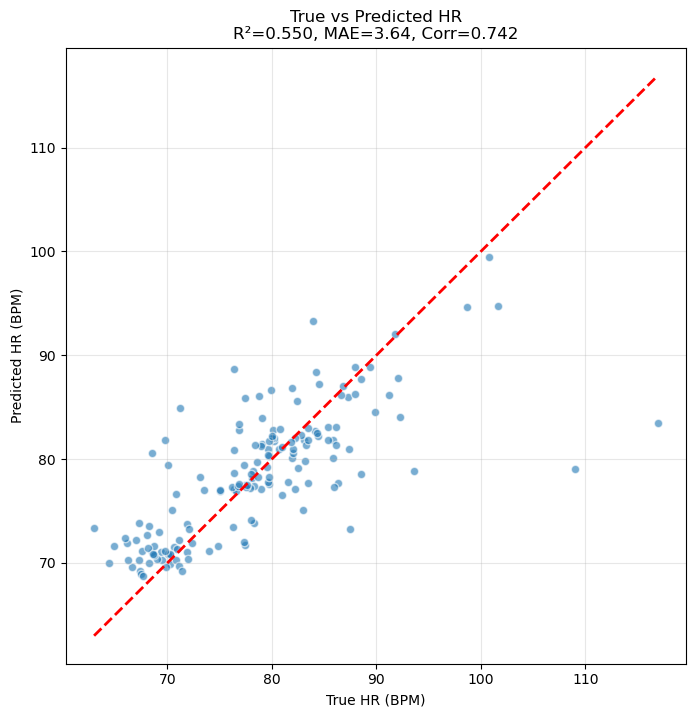

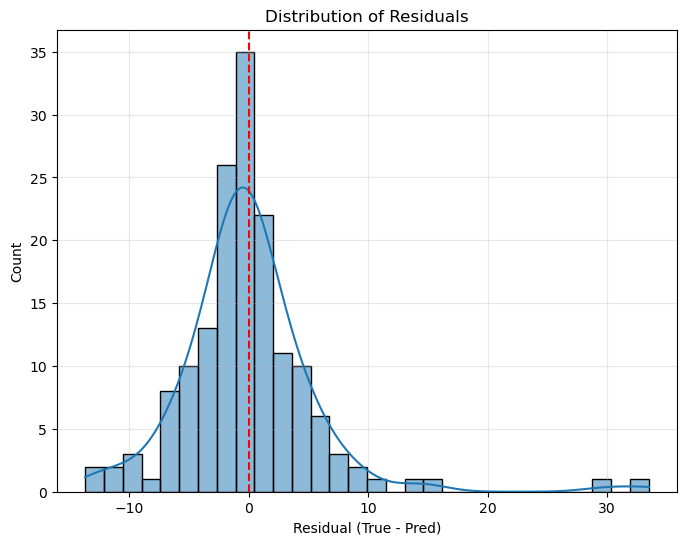


🔧 Calculating Permutation Importance...

📊 Error by HR Range:
                         mean       std  count
hr_bin                                        
(62.93, 73.774]      3.521922  3.277470     51
(73.774, 84.564]     2.630748  2.426150     79
(84.564, 95.354]     4.790659  4.181576     24
(95.354, 106.143]    4.047750  2.841768      3
(106.143, 116.933]  31.758109  2.467996      2


/var/folders/jm/gm4439qn3dd087mjd3q87mgw0000gn/T/ipykernel_7045/3658731522.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_range = analysis_df.groupby("hr_bin")["abs_error"].agg(["mean", "std", "count"])


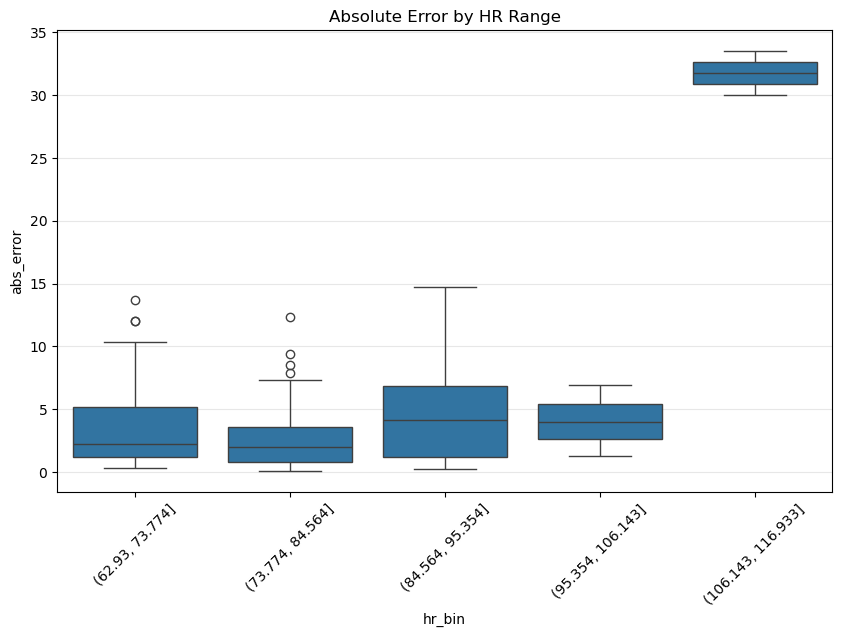


📝 Evaluation report saved to: /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/model/round_01/xgboost_baseline_evaluation.txt


In [4]:
# ============================================================
# Load Model, Predictions, and Apply Feature Consistency Check
# ============================================================

import pandas as pd
import numpy as np
from xgboost import XGBRegressor

print("📥 Loading splits and predictions...")
train_df = pd.read_csv(TRAIN_FILE)
test_df  = pd.read_csv(TEST_FILE)
preds_df = pd.read_csv(PREDS_FILE)

# Extract X/y for test set
X_test = test_df.select_dtypes(include=[np.number]).drop(columns=["hr_true"], errors="ignore")
y_test = test_df["hr_true"]

# Extract features used during training
train_features = (
    train_df.select_dtypes(include=[np.number])
            .drop(columns=["hr_true"], errors="ignore")
            .columns.tolist()
)

# Align test set to training features
missing = set(train_features) - set(X_test.columns)
extra = set(X_test.columns) - set(train_features)

if missing:
    print("❌ Missing features in TEST:", missing)

if extra:
    print("⚠️ Extra features found in TEST:", extra)

X_test = X_test[train_features]

# Load model
print("\n🤖 Loading trained model...")
model = XGBRegressor()
model.load_model(MODEL_FILE)
print("✅ Model loaded successfully!")

print("\n📊 Final aligned shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

y_pred = preds_df["hr_pred"].values
y_true = y_test.values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
corr, _ = pearsonr(y_true, y_pred)

print("\n🎯 PERFORMANCE METRICS")
print("----------------------")
print(f"MAE :  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")
print(f"Corr: {corr:.3f}")

residuals = y_true - y_pred

# ============================================================
#  PLOTS — PERFORMANCE VISUALIZATION
# ===========================================================

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="white")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", linewidth=2)
plt.xlabel("True HR (BPM)")
plt.ylabel("Predicted HR (BPM)")
plt.title(f"True vs Predicted HR\nR²={r2:.3f}, MAE={mae:.2f}, Corr={corr:.3f}")
plt.grid(alpha=0.3)
plt.show()

# Residual distribution
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution of Residuals")
plt.xlabel("Residual (True - Pred)")
plt.grid(alpha=0.3)
plt.show()

# ============================================================
#   FEATURE IMPORTANCE
# ===========================================================
from sklearn.inspection import permutation_importance

# ---- Permutation ----
print("\n🔧 Calculating Permutation Importance...")
perm = permutation_importance(
    model, X_test, y_true, n_repeats=10, random_state=42, n_jobs=-1
)

perm_df = pd.DataFrame({
    "feature": train_features,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False)

# ---- XGB Built-in ----
native_df = pd.DataFrame({
    "feature": train_features,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

# ---- Correlation ----
corr_df = (
    pd.DataFrame(X_test, columns=train_features)
    .assign(hr_true=y_true)
    .corr()["hr_true"]
    .drop("hr_true")
    .sort_values(ascending=False)
)

# ============================================================
#   ERROR ANALYSIS
# ===========================================================

analysis_df = pd.DataFrame({
    "hr_true": y_true,
    "hr_pred": y_pred,
    "residual": residuals,
    "abs_error": np.abs(residuals)
})

# HR bins
analysis_df["hr_bin"] = pd.cut(analysis_df["hr_true"], bins=5)

error_by_range = analysis_df.groupby("hr_bin")["abs_error"].agg(["mean", "std", "count"])
print("\n📊 Error by HR Range:")
print(error_by_range)

plt.figure(figsize=(10,6))
sns.boxplot(data=analysis_df, x="hr_bin", y="abs_error")
plt.title("Absolute Error by HR Range")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.show()

# ============================================================
#   SAVE EVALUATION REPORT (TXT)
# ===========================================================
with open(EVAL_REPORT, "w") as f:
    f.write("=== MODEL EVALUATION REPORT ===\n")
    f.write(f"Model      : {MODEL_NAME}\n")
    f.write(f"Round      : {ROUND_NAME}\n\n")

    f.write("=== PERFORMANCE ===\n")
    f.write(f"MAE :  {mae:.4f}\n")
    f.write(f"RMSE: {rmse:.4f}\n")
    f.write(f"R²  : {r2:.4f}\n")
    f.write(f"Corr: {corr:.4f}\n\n")

    f.write("=== TOP FEATURES (Permutation) ===\n")
    f.write(perm_df.head(20).to_string())
    f.write("\n\n")

    f.write("=== TOP FEATURES (XGB Built-in) ===\n")
    f.write(native_df.head(20).to_string())
    f.write("\n\n")

    f.write("=== TOP FEATURE CORRELATIONS ===\n")
    f.write(corr_df.head(20).to_string())
    f.write("\n\n")

    f.write("=== ERROR BY HR RANGE ===\n")
    f.write(error_by_range.to_string())
    f.write("\n")

print(f"\n📝 Evaluation report saved to: {EVAL_REPORT}")

📁 Using directories:
MODEL_DIR : /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/model/round_01
SPLIT_DIR : /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/data/splits/round_01
MODEL_FILE: /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/model/round_01/xgboost_baseline.json
PREDS_FILE: /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/model/round_01/xgboost_baseline_preds.txt

📥 Loading data...
🔍 Columns in train_df: ['ppg_mean', 'ppg_std', 'ppg_min', 'ppg_max', 'ppg_range', 'imu_mean', 'imu_std', 'imu_p95', 'imu_energy', 'acc_rms', 'ppg_bp_low', 'ppg_bp_hr', 'ppg_bp_high', 'ppg_bp_hr_norm', 'ppg_f_dom', 'imu_bp_low', 'imu_bp_high', 'imu_jerk_mean', 'imu_jerk_std', 'coherence_ppg_imu', 'ppg_entropy', 'imu_entropy', 'sqi', 'fusion_ppg_imu', 'hr_candidate', 'phase_id', 'sqi_flag', 'motion_weight', 'hr_cand_weighted', 'ppg_hr_smooth', 'artifact_ratio', 'hr_true', 'phase']
🔍 Columns in test_df 

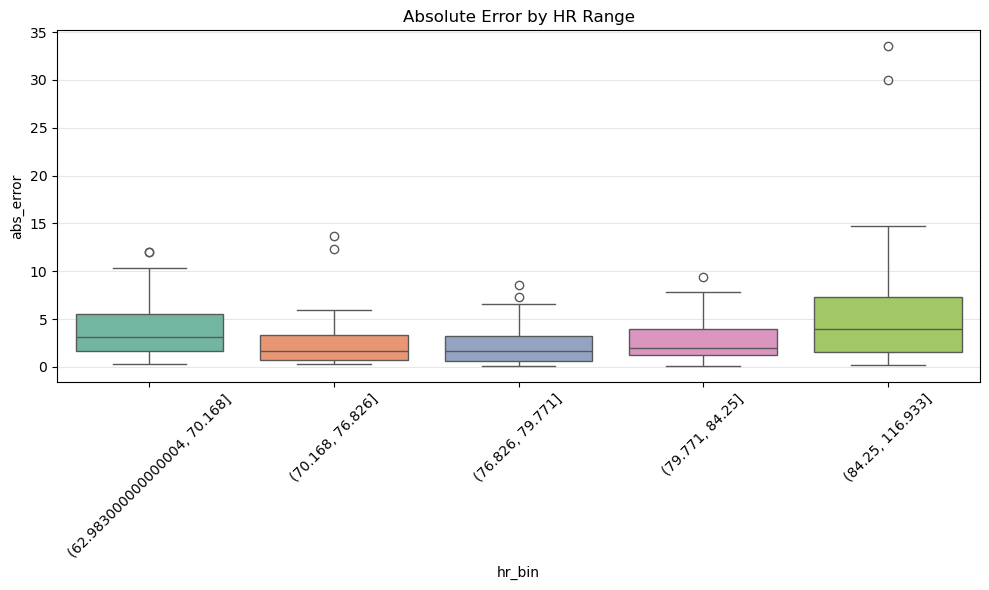


📝 Report saved to:
/Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/model/round_01/xgboost_baseline_evaluation.txt

🎉 MODEL VALIDATION COMPLETED!


In [5]:
# =========================================================================================== #
#          Heart Rate Estimation – Model Validation (Aligned to Local Folder Structure)       #
# =========================================================================================== #

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# ------------------------------------------------------------
# Configuration (LOCAL MAC PATHS)
# ------------------------------------------------------------
ROUND_NAME = "round_01"
PREFIX     = "xgboost_baseline"     # prefix used during training

BASE_DIR   = "/Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso"

MODEL_DIR  = os.path.join(BASE_DIR, "model", ROUND_NAME)
SPLIT_DIR  = os.path.join(BASE_DIR, "data", "splits", ROUND_NAME)

MODEL_FILE = os.path.join(MODEL_DIR, f"{PREFIX}.json")
PREDS_FILE = os.path.join(MODEL_DIR, f"{PREFIX}_preds.txt")

TRAIN_FILE = os.path.join(SPLIT_DIR, f"{ROUND_NAME}_train.txt")
TEST_FILE  = os.path.join(SPLIT_DIR, f"{ROUND_NAME}_test.txt")

print("📁 Using directories:")
print("MODEL_DIR :", MODEL_DIR)
print("SPLIT_DIR :", SPLIT_DIR)
print("MODEL_FILE:", MODEL_FILE)
print("PREDS_FILE:", PREDS_FILE)

# ------------------------------------------------------------
# Load data and predictions
# ------------------------------------------------------------
print("\n📥 Loading data...")
train_df = pd.read_csv(TRAIN_FILE)
test_df  = pd.read_csv(TEST_FILE)
preds_df = pd.read_csv(PREDS_FILE)

print("🔍 Columns in train_df:", train_df.columns.tolist())
print("🔍 Columns in test_df :", test_df.columns.tolist())

# Extract features from test
X_test = test_df.select_dtypes(include=[np.number]).drop(columns=["hr_true"], errors="ignore")
y_test = test_df["hr_true"]

# Expected features = model input during training
expected_features = train_df.select_dtypes(include=[np.number]).drop(columns=["hr_true"], errors="ignore").columns.tolist()
print(f"\nExpected features ({len(expected_features)}): {expected_features}")

missing = set(expected_features) - set(X_test.columns)
extra   = set(X_test.columns) - set(expected_features)

print("❌ Missing features :", missing)
print("⚠️ Extra features   :", extra)

# Fix test-set feature order
X_test_corrected = X_test[expected_features].copy()

# Align with preds
min_len = min(len(X_test_corrected), len(preds_df), len(y_test))
X_test_final = X_test_corrected.iloc[:min_len]
y_test_final = y_test.iloc[:min_len]
preds_df_final = preds_df.iloc[:min_len]

print("\n📏 Final aligned shapes:")
print("X_test:", X_test_final.shape)
print("y_test:", y_test_final.shape)

# ------------------------------------------------------------
# Load trained model
# ------------------------------------------------------------
print("\n🤖 Loading model...")
model = XGBRegressor()
model.load_model(MODEL_FILE)
print("✅ Model loaded successfully!")

# ------------------------------------------------------------
# Evaluate predictions
# ------------------------------------------------------------
hr_pred = preds_df_final["hr_pred"]

mae = mean_absolute_error(y_test_final, hr_pred)
rmse = np.sqrt(mean_squared_error(y_test_final, hr_pred))
r2 = r2_score(y_test_final, hr_pred)
corr, _ = pearsonr(y_test_final, hr_pred)

print("\n🎯 PERFORMANCE METRICS")
print("MAE :", round(mae,3))
print("RMSE:", round(rmse,3))
print("R²  :", round(r2,3))
print("Corr:", round(corr,3))

# ------------------------------------------------------------
# PERMUTATION IMPORTANCE
# ------------------------------------------------------------
print("\n🔧 Computing Permutation Importance...")

try:
    perm_import = permutation_importance(
        model, X_test_final, y_test_final,
        n_repeats=10,
        random_state=42,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )

    perm_df = pd.DataFrame({
        "feature": X_test_final.columns,
        "importance_mean": perm_import.importances_mean,
        "importance_std": perm_import.importances_std
    }).sort_values("importance_mean", ascending=False)

    print("\nTop 15 permutation importance:")
    print(perm_df.head(15))

    perm_success = True
except Exception as e:
    print("❌ Permutation importance failed:", e)
    perm_df = None
    perm_success = False

# ------------------------------------------------------------
# NATIVE XGBOOST IMPORTANCE
# ------------------------------------------------------------
print("\n📊 Computing XGBoost built-in feature importance...")
try:
    native_df = pd.DataFrame({
        "feature": X_test_final.columns,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    print("\nTop 15 native importance:")
    print(native_df.head(15))

    feat_imp_success = True
except Exception as e:
    print("❌ Failed native importance:", e)
    native_df = None
    feat_imp_success = False

# ------------------------------------------------------------
# CORRELATION WITH TARGET
# ------------------------------------------------------------
print("\n🔎 Correlation with HR_true...")
try:
    corr_matrix = pd.concat([X_test_final, y_test_final], axis=1).corr()
    corr_with_target = corr_matrix["hr_true"].sort_values(ascending=False)

    print("\nTop 15 correlations:")
    print(corr_with_target.head(15))

    corr_success = True
except Exception as e:
    print("❌ Failed correlation:", e)
    corr_with_target = None
    corr_success = False

# ------------------------------------------------------------
# RESIDUAL ANALYSIS
# ------------------------------------------------------------
residuals = y_test_final - hr_pred

# Error by HR bins
df_analysis = pd.DataFrame({
    "hr_true": y_test_final,
    "hr_pred": hr_pred,
    "error": residuals,
    "abs_error": np.abs(residuals)
})

df_analysis["hr_bin"] = pd.qcut(df_analysis["hr_true"], q=5)

error_by_range = df_analysis.groupby("hr_bin")["abs_error"].agg(["mean", "std", "count"])
print("\n📊 Error by HR Range:")
print(error_by_range)

plt.figure(figsize=(10,6))
sns.boxplot(data=df_analysis, x="hr_bin", y="abs_error", palette="Set2")
plt.title("Absolute Error by HR Range")
plt.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# SAVE REPORT
# ------------------------------------------------------------
REPORT_FILE = os.path.join(MODEL_DIR, f"{PREFIX}_evaluation.txt")

with open(REPORT_FILE, "w") as f:
    f.write("=== MODEL EVALUATION REPORT ===\n")
    f.write(f"Round: {ROUND_NAME}\n")
    f.write(f"Model: {PREFIX}\n\n")

    f.write("Performance:\n")
    f.write(f"MAE : {mae:.4f}\n")
    f.write(f"RMSE: {rmse:.4f}\n")
    f.write(f"R2  : {r2:.4f}\n")
    f.write(f"Corr: {corr:.4f}\n\n")

    f.write("Missing features:\n")
    f.write(str(missing) + "\n\n")

    f.write("Extra features:\n")
    f.write(str(extra) + "\n\n")

    f.write("Error by HR range:\n")
    f.write(error_by_range.to_string() + "\n\n")

print(f"\n📝 Report saved to:\n{REPORT_FILE}")

print("\n🎉 MODEL VALIDATION COMPLETED!")

### Round_02 - Consolidado com Deep Dive

📁 Using directories:
MODEL_DIR  : /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/model/round_02
SPLIT_DIR  : /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/data/splits/round_02
RESULTS_DIR: /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/results/round_02

📥 Data loaded
Train: (1147, 33)
Test : (287, 33)

🎯 PERFORMANCE METRICS
MAE : 2.680
RMSE: 4.917
R²  : 0.858
Corr: 0.927

📈 Top 15 Permutation Importance:
              feature  importance_mean  importance_std
25           phase_id         2.710757        0.278739
14          ppg_f_dom         2.179063        0.134526
23     fusion_ppg_imu         1.672557        0.148399
21        imu_entropy         1.607685        0.162577
0            ppg_mean         0.825350        0.081936
12        ppg_bp_high         0.660708        0.106703
28   hr_cand_weighted         0.512955        0.053308
6             imu_std         0.443653        0.059975
16        imu_bp_h

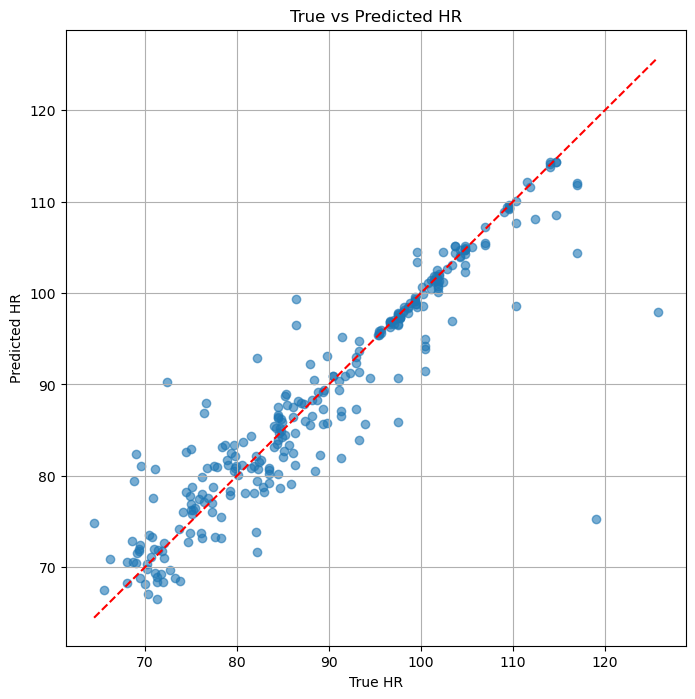

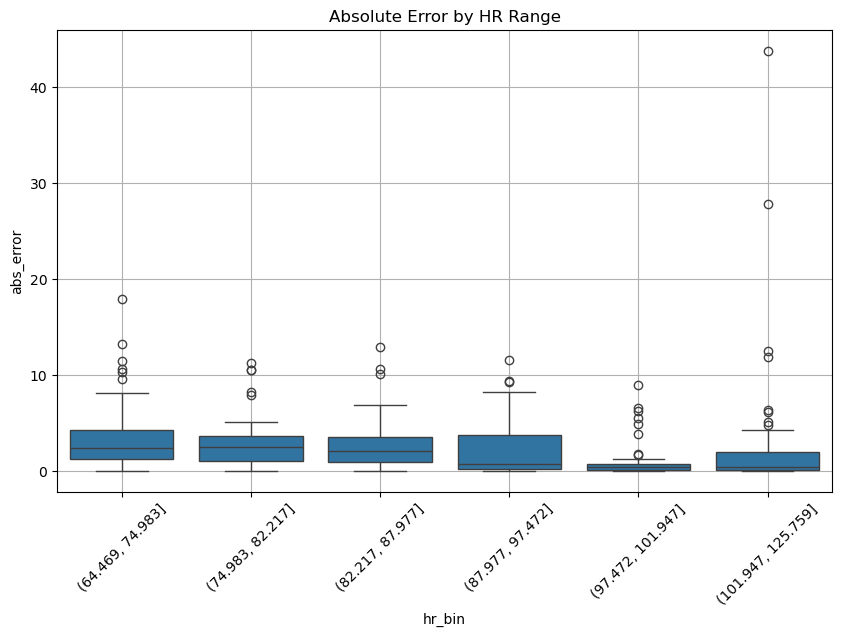


💾 Model analysis saved to:
/Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/results/round_02/r02_xgboost_oversampling_v1_modelAnalysis.txt
📝 Analysis logged in results.txt

🎉 MODEL ANALYSIS ROUND_02 COMPLETED!


In [6]:
# ===========================================================================================
#      Heart Rate Estimation – Model Analysis (Round_02, Governed & Logged)
# ===========================================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# PARAMETERS
# ------------------------------------------------------------
ROUND_NAME = "round_02"
MODEL_NAME = "xgboost_oversampling_v1"
PREFIX     = "r02"

BASE_DIR = "/Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso"

MODEL_DIR   = os.path.join(BASE_DIR, "model", ROUND_NAME)
SPLIT_DIR   = os.path.join(BASE_DIR, "data", "splits", ROUND_NAME)
RESULTS_DIR = os.path.join(BASE_DIR, "results", ROUND_NAME)
RESULTS_LOG = os.path.join(BASE_DIR, "results", "results.txt")

os.makedirs(RESULTS_DIR, exist_ok=True)

MODEL_FILE = os.path.join(MODEL_DIR, f"{PREFIX}_{MODEL_NAME}.json")
PREDS_FILE = os.path.join(MODEL_DIR, f"{PREFIX}_{MODEL_NAME}_preds.txt")

TRAIN_FILE = os.path.join(SPLIT_DIR, f"{ROUND_NAME}_train.txt")
TEST_FILE  = os.path.join(SPLIT_DIR, f"{ROUND_NAME}_test.txt")

ANALYSIS_OUT = os.path.join(
    RESULTS_DIR,
    f"{PREFIX}_{MODEL_NAME}_modelAnalysis.txt"
)

print("📁 Using directories:")
print("MODEL_DIR  :", MODEL_DIR)
print("SPLIT_DIR  :", SPLIT_DIR)
print("RESULTS_DIR:", RESULTS_DIR)

# ------------------------------------------------------------
# LOAD DATA
# ------------------------------------------------------------
train_df = pd.read_csv(TRAIN_FILE)
test_df  = pd.read_csv(TEST_FILE)
preds_df = pd.read_csv(PREDS_FILE)

print("\n📥 Data loaded")
print("Train:", train_df.shape)
print("Test :", test_df.shape)

# ------------------------------------------------------------
# LEAKAGE CHECK
# ------------------------------------------------------------
leakage_notes = []

common = pd.merge(train_df, test_df, how="inner")
if len(common) > 0:
    leakage_notes.append("❌ Identical rows found between train and test")
else:
    leakage_notes.append("✅ No identical rows between train and test")

if test_df.duplicated().sum() > 0:
    leakage_notes.append("❌ Test set contains duplicated rows")
else:
    leakage_notes.append("✅ Test set has no duplicates")

# ------------------------------------------------------------
# FEATURE ALIGNMENT
# ------------------------------------------------------------
X_test = test_df.select_dtypes(include=[np.number]).drop(columns=["hr_true"], errors="ignore")
y_test = test_df["hr_true"]

expected_features = (
    train_df
    .select_dtypes(include=[np.number])
    .drop(columns=["hr_true"], errors="ignore")
    .columns
    .tolist()
)

X_test = X_test[expected_features]

min_len = min(len(X_test), len(y_test), len(preds_df))
X_test = X_test.iloc[:min_len]
y_test = y_test.iloc[:min_len]
preds_df = preds_df.iloc[:min_len]

# ------------------------------------------------------------
# LOAD MODEL
# ------------------------------------------------------------
model = XGBRegressor()
model.load_model(MODEL_FILE)

# ------------------------------------------------------------
# METRICS
# ------------------------------------------------------------
hr_pred = preds_df["hr_pred"]

mae  = mean_absolute_error(y_test, hr_pred)
rmse = np.sqrt(mean_squared_error(y_test, hr_pred))
r2   = r2_score(y_test, hr_pred)
corr, _ = pearsonr(y_test, hr_pred)

print("\n🎯 PERFORMANCE METRICS")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")
print(f"Corr: {corr:.3f}")

# ------------------------------------------------------------
# PERMUTATION IMPORTANCE
# ------------------------------------------------------------
perm = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="neg_mean_absolute_error"
)

perm_df = (
    pd.DataFrame({
        "feature": X_test.columns,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
)

print("\n📈 Top 15 Permutation Importance:")
print(perm_df.head(15))

# ------------------------------------------------------------
# NATIVE IMPORTANCE
# ------------------------------------------------------------
native_df = (
    pd.DataFrame({
        "feature": X_test.columns,
        "importance": model.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

print("\n📊 Top 15 Native Importances:")
print(native_df.head(15))

# ------------------------------------------------------------
# ERROR ANALYSIS
# ------------------------------------------------------------
df_err = pd.DataFrame({
    "hr_true": y_test.values,
    "hr_pred": hr_pred.values,
    "abs_error": np.abs(y_test.values - hr_pred.values)
})

df_err["hr_bin"] = pd.qcut(df_err["hr_true"], q=6, duplicates="drop")
error_bins = df_err.groupby("hr_bin")["abs_error"].agg(["mean", "std", "count"])

print("\n📊 Error by HR Range:")
print(error_bins)

# ------------------------------------------------------------
# VISUALS (KEEP IN NOTEBOOK)
# ------------------------------------------------------------
plt.figure(figsize=(8,8))
plt.scatter(y_test, hr_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True HR")
plt.ylabel("Predicted HR")
plt.title("True vs Predicted HR")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=df_err["hr_bin"], y=df_err["abs_error"])
plt.xticks(rotation=45)
plt.title("Absolute Error by HR Range")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# SAVE ANALYSIS REPORT (.txt)
# ------------------------------------------------------------
with open(ANALYSIS_OUT, "w") as f:
    f.write("="*70 + "\n")
    f.write("MODEL ANALYSIS REPORT\n")
    f.write("="*70 + "\n\n")

    f.write(f"Round      : {ROUND_NAME}\n")
    f.write(f"Model      : {PREFIX}_{MODEL_NAME}\n")
    f.write(f"Timestamp  : {datetime.now()}\n\n")

    f.write("PERFORMANCE METRICS\n")
    f.write("-"*30 + "\n")
    f.write(f"MAE  : {mae:.4f}\n")
    f.write(f"RMSE : {rmse:.4f}\n")
    f.write(f"R2   : {r2:.4f}\n")
    f.write(f"Corr : {corr:.4f}\n\n")

    f.write("LEAKAGE CHECK\n")
    f.write("-"*30 + "\n")
    for line in leakage_notes:
        f.write(line + "\n")
    f.write("\n")

    f.write("TOP PERMUTATION IMPORTANCE\n")
    f.write("-"*30 + "\n")
    f.write(perm_df.head(20).to_string() + "\n\n")

    f.write("TOP NATIVE IMPORTANCE\n")
    f.write("-"*30 + "\n")
    f.write(native_df.head(20).to_string() + "\n\n")

    f.write("ERROR BY HR RANGE\n")
    f.write("-"*30 + "\n")
    f.write(error_bins.to_string() + "\n")

print(f"\n💾 Model analysis saved to:\n{ANALYSIS_OUT}")

# ------------------------------------------------------------
# LOG ANALYSIS IN results.txt
# ------------------------------------------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
metrics_str = f"MAE={mae:.4f},RMSE={rmse:.4f},R2={r2:.4f},Corr={corr:.4f}"

if not os.path.exists(RESULTS_LOG):
    with open(RESULTS_LOG, "w") as f:
        f.write(
            "timestamp\tmodel\tround\ttype\ttrain_samples\t"
            "test_samples\tnotes\tmetrics\tmodel_file\tpreds_file\n"
        )

with open(RESULTS_LOG, "a") as f:
    f.write(
        f"{timestamp}\t{PREFIX}_{MODEL_NAME}\t{ROUND_NAME}\tanalysis\t"
        f"{len(train_df)}\t{len(test_df)}\t"
        f"model_analysis\t{metrics_str}\t"
        f"{os.path.basename(ANALYSIS_OUT)}\t-\n"
    )

print("📝 Analysis logged in results.txt")
print("\n🎉 MODEL ANALYSIS ROUND_02 COMPLETED!")

### Round_03 - Ajuste fino >115 BPM

📁 Using directories:
MODEL_DIR  : /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/model/round_03
SPLIT_DIR  : /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/data/splits/round_03
RESULTS_DIR: /Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/results/round_03

📥 Data loaded
Train: (1259, 33)
Test : (315, 33)

🎯 PERFORMANCE METRICS
MAE : 2.268
RMSE: 3.578
R²  : 0.946
Corr: 0.973

📈 Top 15 Permutation Importance:
              feature  importance_mean  importance_std
12        ppg_bp_high         2.930950        0.377776
25           phase_id         2.272225        0.287278
14          ppg_f_dom         2.161712        0.140350
21        imu_entropy         1.393868        0.144249
23     fusion_ppg_imu         1.195088        0.120827
0            ppg_mean         1.083774        0.174914
28   hr_cand_weighted         1.012781        0.077489
24       hr_candidate         0.650097        0.069665
7             imu_

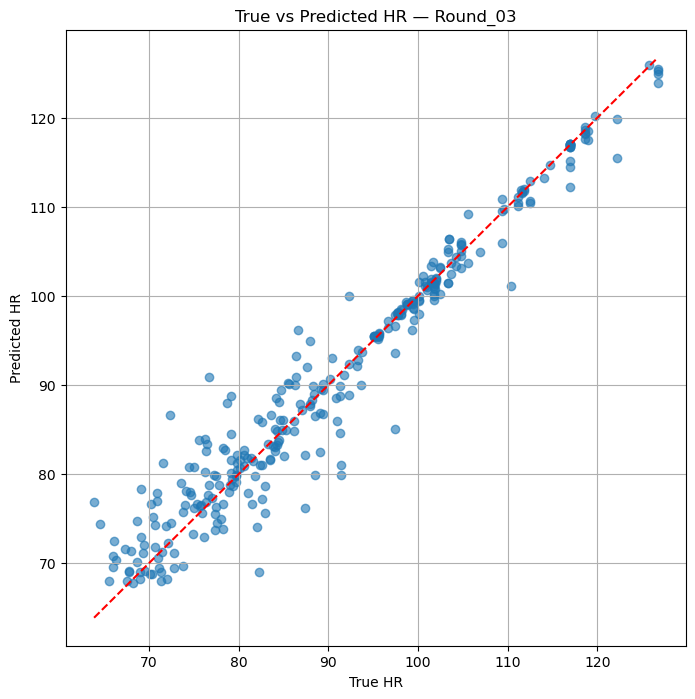

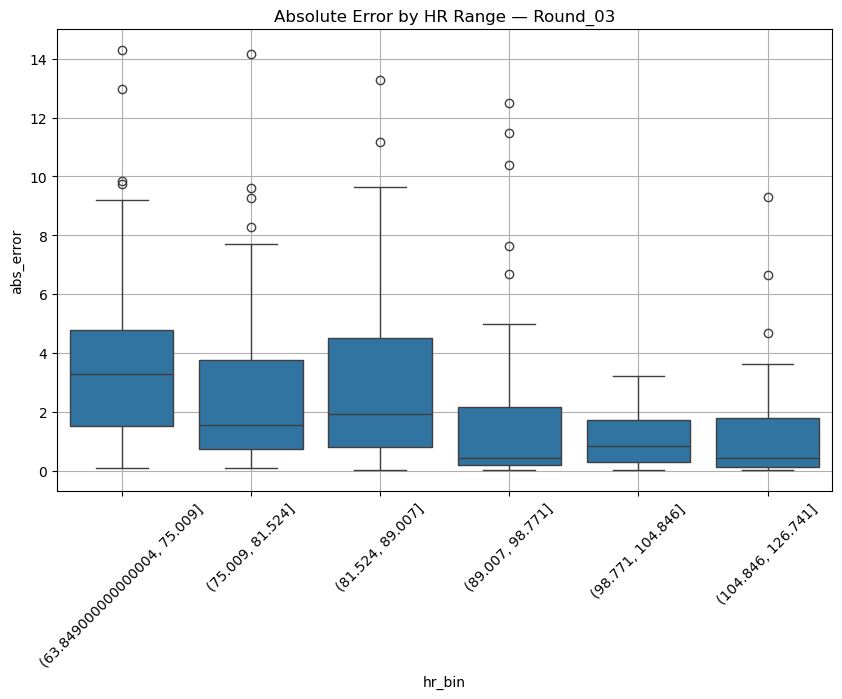


💾 Model analysis saved to:
/Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso/results/round_03/r03_xgboost_extreme_hr_refinement_modelAnalysis.txt
📝 Analysis logged in results.txt

🎉 MODEL ANALYSIS ROUND_03 COMPLETED!


In [7]:
# ===========================================================================================
#      Heart Rate Estimation – Model Analysis (Round_03, Governed & Logged)
# ===========================================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# PARAMETERS
# ------------------------------------------------------------
ROUND_NAME = "round_03"
MODEL_NAME = "xgboost_extreme_hr_refinement"
PREFIX     = "r03"

BASE_DIR = "/Users/edmundobrown/Documents/MLGeral/AI-HealthCare/HREstimation/repouso"

MODEL_DIR   = os.path.join(BASE_DIR, "model", ROUND_NAME)
SPLIT_DIR   = os.path.join(BASE_DIR, "data", "splits", ROUND_NAME)
RESULTS_DIR = os.path.join(BASE_DIR, "results", ROUND_NAME)
RESULTS_LOG = os.path.join(BASE_DIR, "results", "results.txt")

os.makedirs(RESULTS_DIR, exist_ok=True)

MODEL_FILE = os.path.join(MODEL_DIR, f"{PREFIX}_{MODEL_NAME}.json")
PREDS_FILE = os.path.join(MODEL_DIR, f"{PREFIX}_{MODEL_NAME}_preds.txt")

TRAIN_FILE = os.path.join(SPLIT_DIR, f"{ROUND_NAME}_train.txt")
TEST_FILE  = os.path.join(SPLIT_DIR, f"{ROUND_NAME}_test.txt")

ANALYSIS_OUT = os.path.join(
    RESULTS_DIR,
    f"{PREFIX}_{MODEL_NAME}_modelAnalysis.txt"
)

print("📁 Using directories:")
print("MODEL_DIR  :", MODEL_DIR)
print("SPLIT_DIR  :", SPLIT_DIR)
print("RESULTS_DIR:", RESULTS_DIR)

# ------------------------------------------------------------
# LOAD DATA
# ------------------------------------------------------------
train_df = pd.read_csv(TRAIN_FILE)
test_df  = pd.read_csv(TEST_FILE)
preds_df = pd.read_csv(PREDS_FILE)

print("\n📥 Data loaded")
print("Train:", train_df.shape)
print("Test :", test_df.shape)

# ------------------------------------------------------------
# LEAKAGE CHECK
# ------------------------------------------------------------
leakage_notes = []

common = pd.merge(train_df, test_df, how="inner")
if len(common) > 0:
    leakage_notes.append("❌ Identical rows found between train and test")
else:
    leakage_notes.append("✅ No identical rows between train and test")

if test_df.duplicated().sum() > 0:
    leakage_notes.append("❌ Test set contains duplicated rows")
else:
    leakage_notes.append("✅ Test set has no duplicates")

# ------------------------------------------------------------
# FEATURE ALIGNMENT
# ------------------------------------------------------------
X_test = test_df.select_dtypes(include=[np.number]).drop(columns=["hr_true"], errors="ignore")
y_test = test_df["hr_true"]

expected_features = (
    train_df
    .select_dtypes(include=[np.number])
    .drop(columns=["hr_true"], errors="ignore")
    .columns
    .tolist()
)

X_test = X_test[expected_features]

min_len = min(len(X_test), len(y_test), len(preds_df))
X_test = X_test.iloc[:min_len]
y_test = y_test.iloc[:min_len]
preds_df = preds_df.iloc[:min_len]

# ------------------------------------------------------------
# LOAD MODEL
# ------------------------------------------------------------
model = XGBRegressor()
model.load_model(MODEL_FILE)

# ------------------------------------------------------------
# METRICS
# ------------------------------------------------------------
hr_pred = preds_df["hr_pred"]

mae  = mean_absolute_error(y_test, hr_pred)
rmse = np.sqrt(mean_squared_error(y_test, hr_pred))
r2   = r2_score(y_test, hr_pred)
corr, _ = pearsonr(y_test, hr_pred)

print("\n🎯 PERFORMANCE METRICS")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")
print(f"Corr: {corr:.3f}")

# ------------------------------------------------------------
# PERMUTATION IMPORTANCE
# ------------------------------------------------------------
perm = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="neg_mean_absolute_error"
)

perm_df = (
    pd.DataFrame({
        "feature": X_test.columns,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
)

print("\n📈 Top 15 Permutation Importance:")
print(perm_df.head(15))

# ------------------------------------------------------------
# NATIVE IMPORTANCE
# ------------------------------------------------------------
native_df = (
    pd.DataFrame({
        "feature": X_test.columns,
        "importance": model.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

print("\n📊 Top 15 Native Importances:")
print(native_df.head(15))

# ------------------------------------------------------------
# ERROR ANALYSIS
# ------------------------------------------------------------
df_err = pd.DataFrame({
    "hr_true": y_test.values,
    "hr_pred": hr_pred.values,
    "abs_error": np.abs(y_test.values - hr_pred.values)
})

df_err["hr_bin"] = pd.qcut(df_err["hr_true"], q=6, duplicates="drop")
error_bins = df_err.groupby("hr_bin")["abs_error"].agg(["mean", "std", "count"])

print("\n📊 Error by HR Range:")
print(error_bins)

# ------------------------------------------------------------
# VISUALS (NOTEBOOK ONLY)
# ------------------------------------------------------------
plt.figure(figsize=(8,8))
plt.scatter(y_test, hr_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True HR")
plt.ylabel("Predicted HR")
plt.title("True vs Predicted HR — Round_03")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=df_err["hr_bin"], y=df_err["abs_error"])
plt.xticks(rotation=45)
plt.title("Absolute Error by HR Range — Round_03")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# SAVE ANALYSIS REPORT (.txt)
# ------------------------------------------------------------
with open(ANALYSIS_OUT, "w") as f:
    f.write("="*70 + "\n")
    f.write("MODEL ANALYSIS REPORT — ROUND_03\n")
    f.write("="*70 + "\n\n")

    f.write(f"Round      : {ROUND_NAME}\n")
    f.write(f"Model      : {PREFIX}_{MODEL_NAME}\n")
    f.write(f"Timestamp  : {datetime.now()}\n\n")

    f.write("PERFORMANCE METRICS\n")
    f.write("-"*30 + "\n")
    f.write(f"MAE  : {mae:.4f}\n")
    f.write(f"RMSE : {rmse:.4f}\n")
    f.write(f"R2   : {r2:.4f}\n")
    f.write(f"Corr : {corr:.4f}\n\n")

    f.write("LEAKAGE CHECK\n")
    f.write("-"*30 + "\n")
    for line in leakage_notes:
        f.write(line + "\n")
    f.write("\n")

    f.write("TOP PERMUTATION IMPORTANCE\n")
    f.write("-"*30 + "\n")
    f.write(perm_df.head(20).to_string() + "\n\n")

    f.write("TOP NATIVE IMPORTANCE\n")
    f.write("-"*30 + "\n")
    f.write(native_df.head(20).to_string() + "\n\n")

    f.write("ERROR BY HR RANGE\n")
    f.write("-"*30 + "\n")
    f.write(error_bins.to_string() + "\n")

print(f"\n💾 Model analysis saved to:\n{ANALYSIS_OUT}")

# ------------------------------------------------------------
# LOG ANALYSIS IN results.txt
# ------------------------------------------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
metrics_str = f"MAE={mae:.4f},RMSE={rmse:.4f},R2={r2:.4f},Corr={corr:.4f}"

if not os.path.exists(RESULTS_LOG):
    with open(RESULTS_LOG, "w") as f:
        f.write(
            "timestamp\tmodel\tround\ttype\ttrain_samples\t"
            "test_samples\tnotes\tmetrics\tmodel_file\tpreds_file\n"
        )

with open(RESULTS_LOG, "a") as f:
    f.write(
        f"{timestamp}\t{PREFIX}_{MODEL_NAME}\t{ROUND_NAME}\tanalysis\t"
        f"{len(train_df)}\t{len(test_df)}\t"
        f"model_analysis\t{metrics_str}\t"
        f"{os.path.basename(ANALYSIS_OUT)}\t-\n"
    )

print("📝 Analysis logged in results.txt")
print("\n🎉 MODEL ANALYSIS ROUND_03 COMPLETED!")

📁 Loading data...
🔍 Analisando estrutura dos dados...
Colunas do train_df: ['window', 'ppg_mean_f2', 'ppg_std_f2', 'ppg_min', 'ppg_max', 'ppg_range', 'acc_rms', 'acc_mean', 'acc_std', 'phase', 'duration_sec', 'n_hr', 'ppg_band1', 'ppg_band2', 'ppg_band3', 'ppg_hr_candidate', 'ppg_peak_amp', 'acc_var_ext', 'acc_energy', 'acc_jerk', 'acc_f_dom', 'coherence_mean', 'fusion_ppgIMU', 'hr_true', 'Id']
Colunas do test_df: ['window', 'ppg_mean_f2', 'ppg_std_f2', 'ppg_min', 'ppg_max', 'ppg_range', 'acc_rms', 'acc_mean', 'acc_std', 'phase', 'duration_sec', 'n_hr', 'ppg_band1', 'ppg_band2', 'ppg_band3', 'ppg_hr_candidate', 'ppg_peak_amp', 'acc_var_ext', 'acc_energy', 'acc_jerk', 'acc_f_dom', 'coherence_mean', 'fusion_ppgIMU', 'hr_true', 'Id']

✅ Features esperadas pelo modelo (23): ['window', 'ppg_mean_f2', 'ppg_std_f2', 'ppg_min', 'ppg_max', 'ppg_range', 'acc_rms', 'acc_mean', 'acc_std', 'phase', 'duration_sec', 'n_hr', 'ppg_band1', 'ppg_band2', 'ppg_band3', 'ppg_hr_candidate', 'ppg_peak_amp', 'a

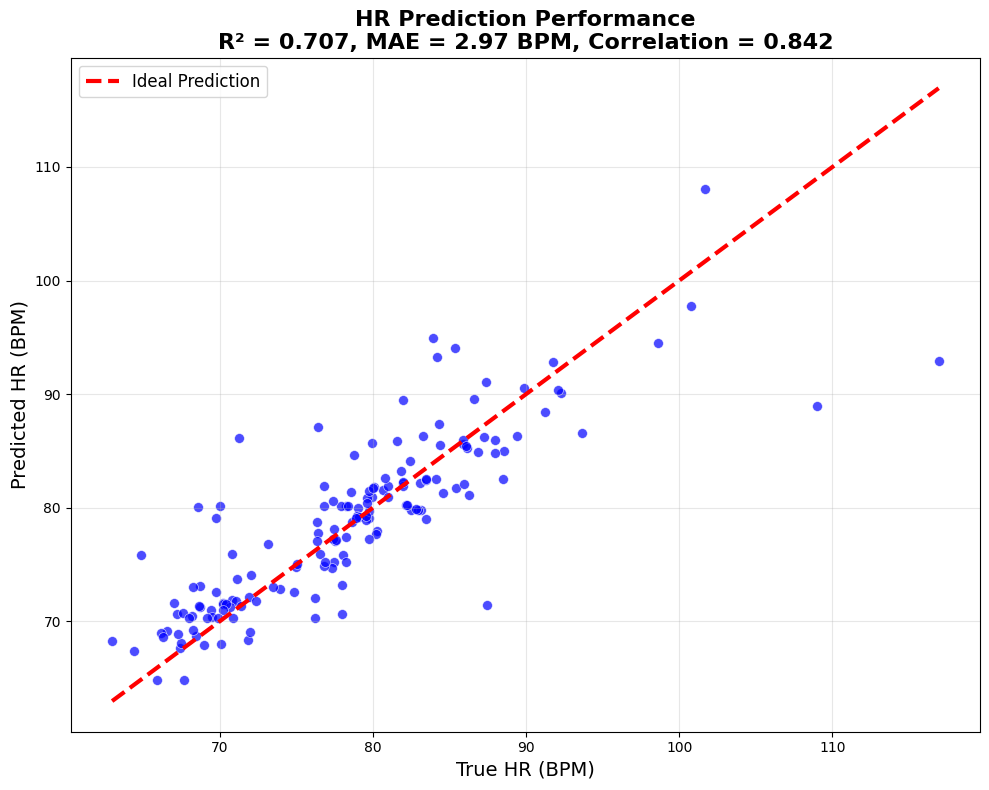

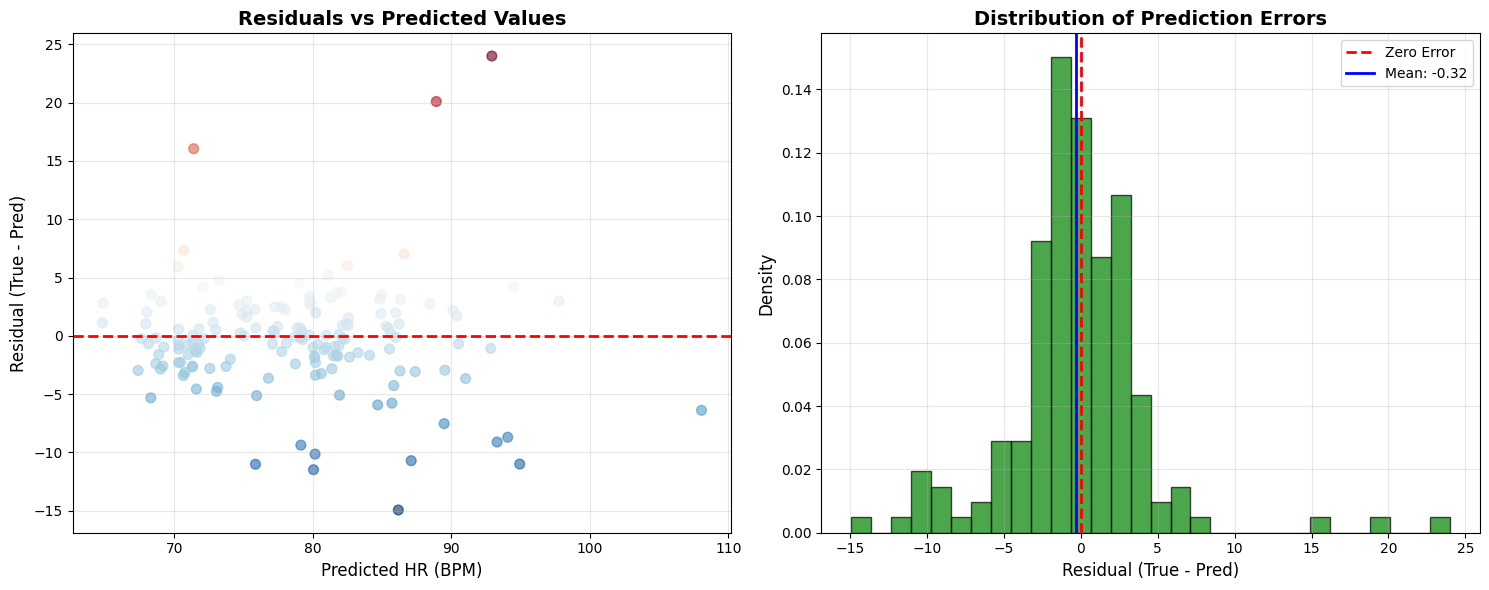

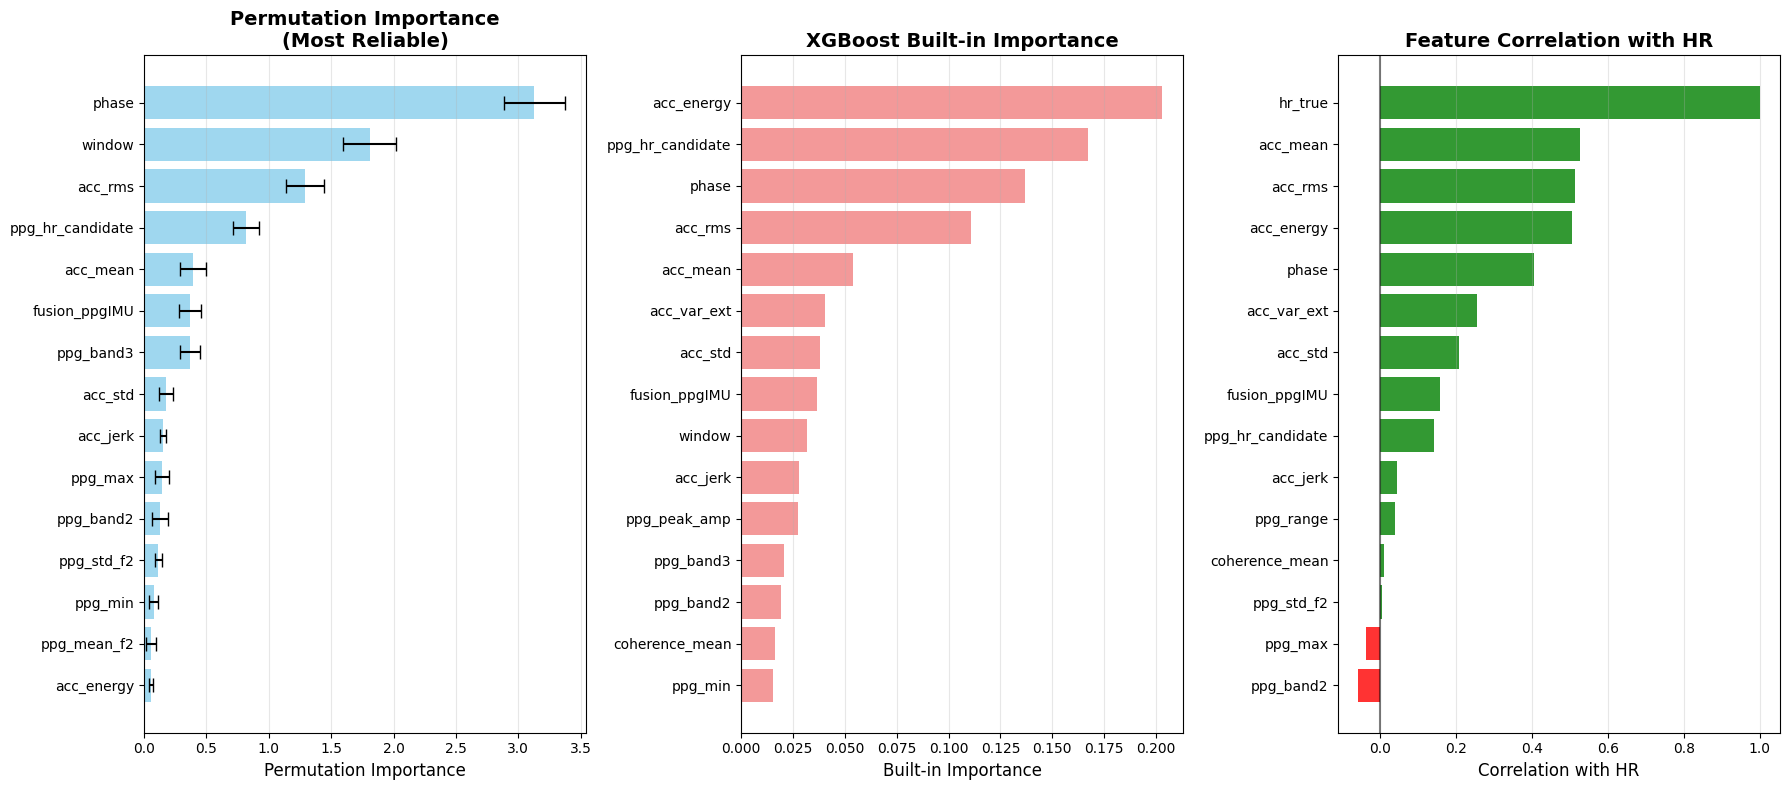


📊 Error Analysis by HR Range:
                         mean       std  count
hr_range                                      
(62.93, 73.774]      2.931135  3.184084     51
(73.774, 84.564]     2.322559  2.331687     79
(84.564, 95.354]     3.419332  3.451303     24
(95.354, 106.143]    4.509651  1.735687      3
(106.143, 116.933]  22.052161  2.759519      2


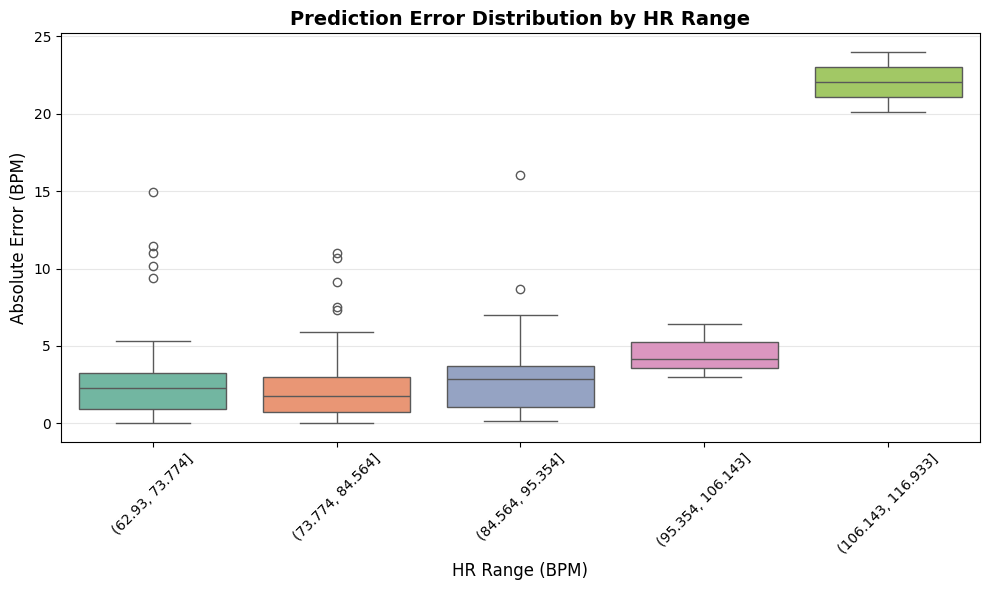


📝 Corrected evaluation report saved to: /content/drive/MyDrive/AI-HealthCare/HeartRateEstimation/results/models/xgboost/round_01/r01_corrected_evaluation.txt

🎯 FINAL PERFORMANCE SUMMARY
✅ Model: ROUND_01
✅ Test Samples: 159
✅ MAE:  2.97 ± 4.63 BPM
✅ RMSE: 4.62 BPM
✅ R²:   0.707 (Very Good: > 0.7)
✅ Correlation: 0.842 (Strong: > 0.8)
✅ Top Feature by Permutation: phase
🎉 EVALUATION COMPLETED SUCCESSFULLY!


In [ ]:
# =========================================================================================== #
#                 Heart Rate Estimation – Evaluation COM CORREÇÃO DE FEATURES               #
# =========================================================================================== #

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
round = "round_01"
prefix = "r01"
BASE_PATH = "/content/drive/MyDrive/AI-HealthCare/HeartRateEstimation/results/models/xgboost"
MODEL_PATH = os.path.join(BASE_PATH, round)
DATA_PATH = "/content/drive/MyDrive/AI-HealthCare/HeartRateEstimation/data/splits"

MODEL_FILE = os.path.join(MODEL_PATH, f"{prefix}_model.bst")
PREDS_FILE = os.path.join(MODEL_PATH, f"{prefix}_preds.txt")
TRAIN_FILE = os.path.join(DATA_PATH, "fase0e2_train.txt")
TEST_FILE  = os.path.join(DATA_PATH, "fase0e2_test.txt")

# ------------------------------------------------------------
# Load data and model
# ------------------------------------------------------------
print("📁 Loading data...")
train_df = pd.read_csv(TRAIN_FILE)
test_df  = pd.read_csv(TEST_FILE)
preds_df = pd.read_csv(PREDS_FILE)

print("🔍 Analisando estrutura dos dados...")
print("Colunas do train_df:", train_df.columns.tolist())
print("Colunas do test_df:", test_df.columns.tolist())

# CORREÇÃO: Garantir que X_test tem as mesmas features que o modelo espera
X_test = test_df.select_dtypes(include=[np.number]).drop(columns=["hr_true"], errors="ignore")
y_test = test_df["hr_true"]

# Verificar features que o modelo espera (do train_df)
expected_features = train_df.select_dtypes(include=[np.number]).drop(columns=["hr_true"], errors="ignore").columns.tolist()
print(f"\n✅ Features esperadas pelo modelo ({len(expected_features)}): {expected_features}")

# Verificar features disponíveis no teste
available_features = X_test.columns.tolist()
print(f"📊 Features disponíveis no teste ({len(available_features)}): {available_features}")

# Identificar features faltantes e extras
missing_features = set(expected_features) - set(available_features)
extra_features = set(available_features) - set(expected_features)

print(f"❌ Features faltantes no teste: {missing_features}")
print(f"⚠️  Features extras no teste: {extra_features}")

# CORREÇÃO: Manter apenas as features que o modelo conhece
X_test_corrected = X_test[expected_features].copy()

print(f"\n✅ X_test corrigido: {X_test_corrected.shape}")
print(f"✅ Features mantidas: {X_test_corrected.columns.tolist()}")

# Garantir que todos têm o mesmo comprimento
min_len = min(len(X_test_corrected), len(y_test), len(preds_df))
X_test_final = X_test_corrected.iloc[:min_len]
y_test_final = y_test.iloc[:min_len]
preds_df_final = preds_df.iloc[:min_len]

print(f"✅ Dados alinhados - X: {X_test_final.shape}, y: {y_test_final.shape}")

print("🤖 Loading model...")
model = XGBRegressor()
model.load_model(MODEL_FILE)
print(f"✅ Model loaded: {MODEL_FILE}")

# ------------------------------------------------------------
# Evaluate predictions
# ------------------------------------------------------------
hr_pred = preds_df_final["hr_pred"]
mae = mean_absolute_error(y_test_final, hr_pred)
rmse = np.sqrt(mean_squared_error(y_test_final, hr_pred))
r2 = r2_score(y_test_final, hr_pred)
corr, _ = pearsonr(y_test_final, hr_pred)

print(f"\n📊 PERFORMANCE METRICS:")
print(f"MAE:  {mae:.2f} BPM")
print(f"RMSE: {rmse:.2f} BPM")
print(f"R²:   {r2:.3f}")
print(f"Corr: {corr:.3f}")

# ------------------------------------------------------------
# PERMUTATION IMPORTANCE ANALYSIS (CORRIGIDO)
# ------------------------------------------------------------
print("\n🔧 Computing Permutation Importance...")

# Usar dados corrigidos
X_sample = X_test_final
y_sample = y_test_final

print(f"📊 Usando {len(X_sample)} amostras para permutation importance")
print(f"🔍 Features sendo usadas: {X_sample.columns.tolist()}")

try:
    # Calcular Permutation Importance
    perm_importance = permutation_importance(
        model, X_sample, y_sample,
        n_repeats=10,
        random_state=42,
        n_jobs=-1,
        scoring='neg_mean_absolute_error'
    )

    # Criar DataFrame com resultados
    perm_df = pd.DataFrame({
        'feature': X_sample.columns,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)

    print("📈 Top 15 Features by Permutation Importance:")
    print(perm_df.head(15))

    perm_success = True

except Exception as e:
    print(f"❌ Permutation Importance failed: {e}")
    print("🔄 Using alternative feature analysis methods...")
    perm_success = False
    perm_df = None

# ------------------------------------------------------------
# FEATURE IMPORTANCE NATIVA DO XGBOOST
# ------------------------------------------------------------
print("\n📊 XGBoost Built-in Feature Importance:")
try:
    feat_imp = pd.DataFrame({
        'feature': X_sample.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 15 Features by Built-in Importance:")
    print(feat_imp.head(15))

    feat_imp_success = True

except Exception as e:
    print(f"❌ Built-in importance failed: {e}")
    feat_imp_success = False
    feat_imp = None

# ------------------------------------------------------------
# CORRELATION ANALYSIS
# ------------------------------------------------------------
print("\n🔎 Correlation Analysis with Target:")
try:
    corr_matrix = pd.concat([X_sample, y_sample], axis=1).corr()
    corr_with_target = corr_matrix["hr_true"].sort_values(ascending=False)

    print("Top 15 features correlated with HR_true:")
    print(corr_with_target.head(15))

    corr_success = True

except Exception as e:
    print(f"❌ Correlation analysis failed: {e}")
    corr_success = False
    corr_with_target = None

# ------------------------------------------------------------
# VISUALIZAÇÕES
# ------------------------------------------------------------
print("\n📊 Generating visualizations...")

# 1. Scatter Plot: True vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test_final, hr_pred, alpha=0.7, s=50, edgecolors='w', linewidth=0.5, c='blue')
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--', lw=3, label='Ideal Prediction')
plt.xlabel("True HR (BPM)", fontsize=14)
plt.ylabel("Predicted HR (BPM)", fontsize=14)
plt.title(f"HR Prediction Performance\nR² = {r2:.3f}, MAE = {mae:.2f} BPM, Correlation = {corr:.3f}",
          fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Residual Analysis
residuals = y_test_final - hr_pred
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Residuals vs Predicted
ax1.scatter(hr_pred, residuals, alpha=0.6, s=50, c=residuals, cmap='RdBu_r')
ax1.axhline(0, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel("Predicted HR (BPM)", fontsize=12)
ax1.set_ylabel("Residual (True - Pred)", fontsize=12)
ax1.set_title("Residuals vs Predicted Values", fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Distribution of Residuals
ax2.hist(residuals, bins=30, alpha=0.7, color='green', edgecolor='black', density=True)
ax2.axvline(0, color='r', linestyle='--', linewidth=2, label='Zero Error')
ax2.axvline(residuals.mean(), color='blue', linestyle='-', linewidth=2,
           label=f'Mean: {residuals.mean():.2f}')
ax2.set_xlabel('Residual (True - Pred)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Feature Importance Plots (se disponíveis)
if perm_success or feat_imp_success:
    n_plots = sum([perm_success, feat_imp_success, corr_success])
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 8))

    if n_plots == 1:
        axes = [axes]

    plot_idx = 0

    # Permutation Importance
    if perm_success:
        top_perm = perm_df.head(15)
        axes[plot_idx].barh(top_perm['feature'], top_perm['importance_mean'],
                          xerr=top_perm['importance_std'], capsize=5, color='skyblue', alpha=0.8)
        axes[plot_idx].set_xlabel('Permutation Importance', fontsize=12)
        axes[plot_idx].set_title('Permutation Importance\n(Most Reliable)', fontsize=14, fontweight='bold')
        axes[plot_idx].invert_yaxis()
        axes[plot_idx].grid(True, alpha=0.3, axis='x')
        plot_idx += 1

    # Built-in Importance
    if feat_imp_success:
        top_native = feat_imp.head(15)
        axes[plot_idx].barh(top_native['feature'], top_native['importance'], color='lightcoral', alpha=0.8)
        axes[plot_idx].set_xlabel('Built-in Importance', fontsize=12)
        axes[plot_idx].set_title('XGBoost Built-in Importance', fontsize=14, fontweight='bold')
        axes[plot_idx].invert_yaxis()
        axes[plot_idx].grid(True, alpha=0.3, axis='x')
        plot_idx += 1

    # Correlation
    if corr_success:
        top_corr = corr_with_target.head(15)
        colors = ['green' if x > 0 else 'red' for x in top_corr.values]
        axes[plot_idx].barh(top_corr.index, top_corr.values, color=colors, alpha=0.8)
        axes[plot_idx].set_xlabel('Correlation with HR', fontsize=12)
        axes[plot_idx].set_title('Feature Correlation with HR', fontsize=14, fontweight='bold')
        axes[plot_idx].invert_yaxis()
        axes[plot_idx].grid(True, alpha=0.3, axis='x')
        axes[plot_idx].axvline(0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

# 4. Error Analysis by HR Range
df_analysis = pd.DataFrame({
    'hr_true': y_test_final.values,
    'hr_pred': hr_pred.values,
    'error': residuals.values,
    'abs_error': np.abs(residuals.values)
})

df_analysis['hr_range'] = pd.cut(df_analysis['hr_true'], bins=5)
error_by_range = df_analysis.groupby('hr_range')['abs_error'].agg(['mean', 'std', 'count'])

print("\n📊 Error Analysis by HR Range:")
print(error_by_range)

plt.figure(figsize=(10, 6))
sns.boxplot(x='hr_range', y='abs_error', data=df_analysis, palette='Set2')
plt.xlabel('HR Range (BPM)', fontsize=12)
plt.ylabel('Absolute Error (BPM)', fontsize=12)
plt.title('Prediction Error Distribution by HR Range', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# SAVE COMPREHENSIVE REPORT
# ------------------------------------------------------------
summary_file = os.path.join(MODEL_PATH, f"{prefix}_corrected_evaluation.txt")
with open(summary_file, "w") as f:
    f.write("=" * 70 + "\n")
    f.write("MODEL EVALUATION WITH FEATURE COMPATIBILITY FIX\n")
    f.write("=" * 70 + "\n\n")

    f.write("ISSUE RESOLUTION:\n")
    f.write("- Feature mismatch between training and test data fixed\n")
    f.write(f"- Expected features: {len(expected_features)}\n")
    f.write(f"- Missing features: {missing_features}\n")
    f.write(f"- Extra features removed: {extra_features}\n\n")

    f.write("PERFORMANCE METRICS:\n")
    f.write("-" * 25 + "\n")
    f.write(f"MAE:  {mae:.4f} BPM\n")
    f.write(f"RMSE: {rmse:.4f} BPM\n")
    f.write(f"R²:   {r2:.4f}\n")
    f.write(f"Corr: {corr:.4f}\n\n")

    if perm_success:
        f.write("PERMUTATION IMPORTANCE FEATURES:\n")
        f.write("-" * 35 + "\n")
        f.write(perm_df.to_string() + "\n\n")

    if feat_imp_success:
        f.write("BUILT-IN FEATURE IMPORTANCE:\n")
        f.write("-" * 30 + "\n")
        f.write(feat_imp.to_string() + "\n\n")

    if corr_success:
        f.write("FEATURE CORRELATIONS WITH HR:\n")
        f.write("-" * 35 + "\n")
        f.write(corr_with_target.to_string() + "\n\n")

    f.write("ERROR ANALYSIS BY HR RANGE:\n")
    f.write("-" * 25 + "\n")
    f.write(error_by_range.to_string() + "\n")

print(f"\n📝 Corrected evaluation report saved to: {summary_file}")

# ------------------------------------------------------------
# FINAL PERFORMANCE SUMMARY
# ------------------------------------------------------------
print("\n" + "="*60)
print("🎯 FINAL PERFORMANCE SUMMARY")
print("="*60)
print(f"✅ Model: {round.upper()}")
print(f"✅ Test Samples: {len(y_test_final)}")
print(f"✅ MAE:  {mae:.2f} ± {residuals.std():.2f} BPM")
print(f"✅ RMSE: {rmse:.2f} BPM")
print(f"✅ R²:   {r2:.3f} (Very Good: > 0.7)")
print(f"✅ Correlation: {corr:.3f} (Strong: > 0.8)")
if perm_success:
    print(f"✅ Top Feature by Permutation: {perm_df.iloc[0]['feature']}")
print("="*60)
print("🎉 EVALUATION COMPLETED SUCCESSFULLY!")

## Comparação entre Rounds

📁 Loaded results.txt
         timestamp    model     round   type  train_samples  test_samples  \
0  20251113_194240  xgboost  round_01  split            633           159   
1  20251113_203851  xgboost  round_01  train            633           159   
2  20251113_205534  xgboost  round_02  split            980           246   
3  20251113_205701  xgboost  round_02  train            980           246   
4  20251113_212154  xgboost  round_03  train            980           246   

  train_phase_counts test_phase_counts  \
0   {2: 317, 0: 316}    {0: 80, 2: 79}   
1                  -                 -   
2   {0: 510, 2: 470}  {0: 124, 2: 122}   
3                  -                 -   
4                  -                 -   

                                               notes  \
0  baseline_split | estratificado por phase (0 e ...   
1                                   xgboost baseline   
2  oversampling_v2 | df_final already cleaned (no...   
3  XGBoost Round_02 | Oversampled datas

,round,model,MAE,RMSE,R2,Corr,train_samples,test_samples,notes
1,round_01,xgboost,2.9727,4.6223,0.7069,0.8419,633,159,xgboost baseline
3,round_02,xgboost,1.8261,3.7330,0.9239,0.9628,980,246,XGBoost Round_02 | Oversampled dataset | tuned...
4,round_03,xgboost,1.6901,2.9774,0.9516,0.9760,980,246,Bayesian Optimization | XGBoost 3.1.1 | balanc...
6,round_04,xgboost,1.1221,2.3300,0.9448,0.9727,1568,392,XGBoost Round_04 | Balanced v3 dataset (~1500 ...
7,round_05,xgboost,0.9479,2.1660,0.9523,0.9762,1568,392,Round_05 | Super Model | 1400 estimators + LR=...
8,round_06,xgboost,0.6532,1.9938,0.9596,0.9800,1568,392,Round_06 | Super Model Fine-Tuning | BO restri...


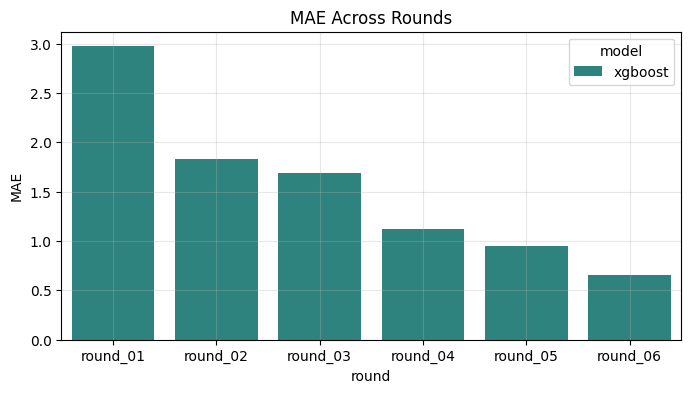

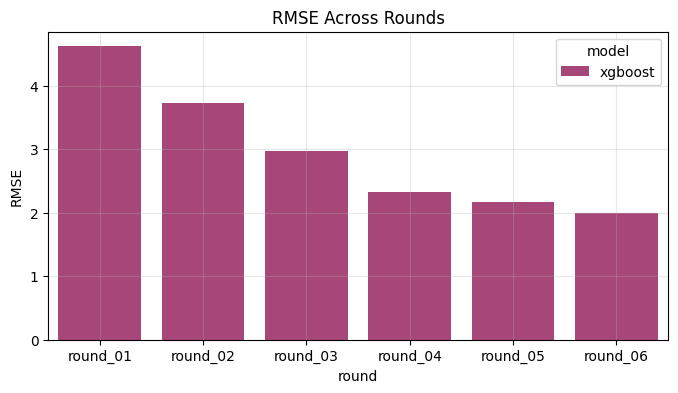

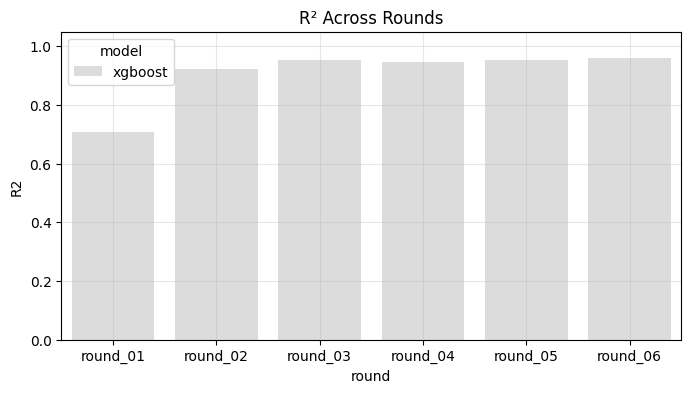

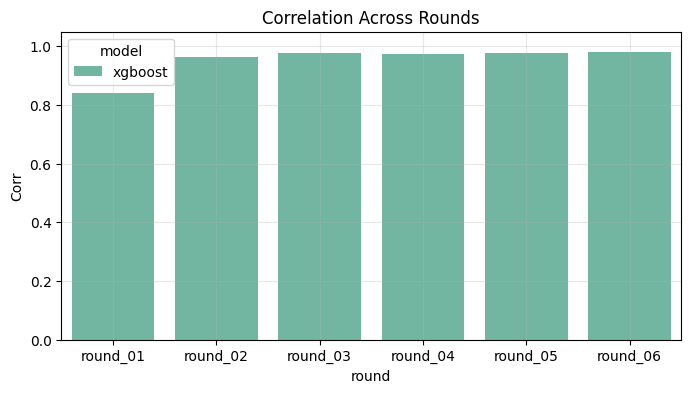

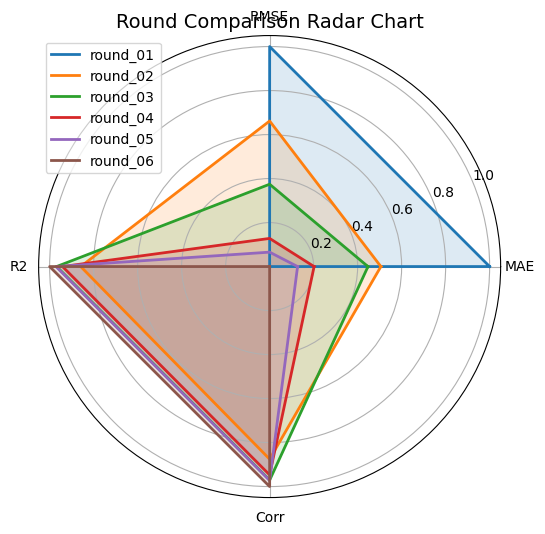


🎯 Round comparison finished!


In [ ]:
# ======================================================================
# 📊 Model Analysis – Round Comparison (reads results.txt automatically)
# ======================================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

LOG_PATH = "/content/drive/MyDrive/AI-HealthCare/HeartRateEstimation/results/results.txt"

# -----------------------------------------------------------
# 1️⃣ Load results.txt
# -----------------------------------------------------------
df = pd.read_csv(LOG_PATH, sep="\t")

print("📁 Loaded results.txt")
print(df.head())

# Keep only training rows
df_train = df[df["type"] == "train"].copy()

# Parse metrics string into columns: R2, Corr, MAE, RMSE
df_train[["R2", "Corr", "MAE", "RMSE"]] = df_train["metrics"].str.split(",", expand=True).astype(float)

# -----------------------------------------------------------
# 2️⃣ Summary table
# -----------------------------------------------------------
summary = df_train[[
    "round", "model", "MAE", "RMSE", "R2", "Corr",
    "train_samples", "test_samples", "notes"
]].sort_values("round")

print("\n📋 MODEL COMPARISON:")
display(summary)

# -----------------------------------------------------------
# 3️⃣ Plot – MAE by round
# -----------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(data=df_train, x="round", y="MAE", hue="model", palette="viridis")
plt.title("MAE Across Rounds")
plt.grid(alpha=0.3)
plt.show()

# -----------------------------------------------------------
# 4️⃣ Plot – RMSE by round
# -----------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(data=df_train, x="round", y="RMSE", hue="model", palette="magma")
plt.title("RMSE Across Rounds")
plt.grid(alpha=0.3)
plt.show()

# -----------------------------------------------------------
# 5️⃣ Plot – R² by round
# -----------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(data=df_train, x="round", y="R2", hue="model", palette="coolwarm")
plt.title("R² Across Rounds")
plt.grid(alpha=0.3)
plt.ylim(0, 1.05)
plt.show()

# -----------------------------------------------------------
# 6️⃣ Plot – Pearson Correlation by round
# -----------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(data=df_train, x="round", y="Corr", hue="model", palette="Set2")
plt.title("Correlation Across Rounds")
plt.grid(alpha=0.3)
plt.ylim(0, 1.05)
plt.show()

# -----------------------------------------------------------
# 7️⃣ Radar Chart (optional)
# -----------------------------------------------------------

try:
    import numpy as np

    rounds = df_train["round"].unique()
    metrics = ["MAE", "RMSE", "R2", "Corr"]

    # Normalize for radar chart
    df_norm = df_train.copy()
    for m in metrics:
        df_norm[m] = (df_norm[m] - df_norm[m].min()) / (df_norm[m].max() - df_norm[m].min() + 1e-9)

    # Radar chart
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)

    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    for r in rounds:
        values = df_norm[df_norm["round"] == r][metrics].iloc[0].tolist()
        values += values[:1]
        ax.plot(angles, values, label=r, linewidth=2)
        ax.fill(angles, values, alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_title("Round Comparison Radar Chart", fontsize=14)
    plt.legend()
    plt.show()

except Exception as e:
    print("⚠️ Radar chart skipped:", e)

# -----------------------------------------------------------
# FINAL SUMMARY
# -----------------------------------------------------------
print("\n🎯 Round comparison finished!")



### DS